In [37]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

In [116]:
def lorentzian(x, x0, gamma, A):
    return (A * (gamma**2)) / ((x - x0)**2 + gamma**2)

In [62]:
# Load PNG image
image_path = "LNB_Raman.png"   # <-- change this
img = Image.open(image_path).convert("RGB")

# Convert image to NumPy array
pixels = np.array(img)

# Define what "red" means (tweak thresholds if needed)
# Red pixel: high R, low G, low B
red_threshold = 150
green_threshold = 100
blue_threshold = 100

# Find red pixels
red_pixels = np.where(
    (pixels[:, :, 0] > red_threshold) &   # Red channel
    (pixels[:, :, 1] < green_threshold) & # Green channel
    (pixels[:, :, 2] < blue_threshold)    # Blue channel
)

# Extract positions as (x, y)
positions = list(zip(red_pixels[1], red_pixels[0]))

data = np.array([[float(point[0]), float(point[1])] for point in positions])

x = data[:, 0]
y = np.max(data[:, 1])-data[:, 1]

x_corr = np.zeros_like(x)
y_corr = np.zeros_like(x)

for i,x_val in enumerate(x):
    #166->0, 682->1200
    x_corr[i] = 0 + (x_val-166)*(1200-0)/(682-166)
    y_corr[i] = y[x==x_val].mean()

y_corr = y_corr/np.max(y_corr)

x_arr = np.sort(x_corr)
y_arr = y_corr[np.argsort(x_corr)]

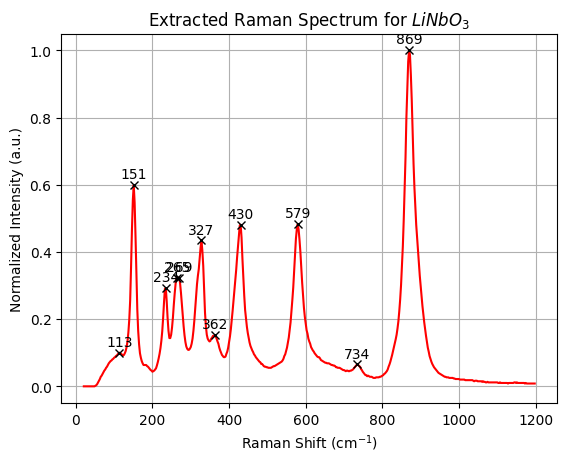

In [66]:
plt.plot(x_arr, y_arr, 'r-', markersize=1)

peaks, properties = find_peaks(
    y_arr,
    height=0.01,        # minimum peak height
    distance=5,      # minimum distance between peaks
    prominence=0.005     # peak prominence
)

plt.plot(x_arr[peaks], y_arr[peaks], "kx")

for peak in peaks:
    plt.text(x_arr[peak], y_arr[peak]+0.02, f"{int(x_arr[peak])}", ha='center')
plt.xlabel("Raman Shift (cm$^{-1}$)")
plt.ylabel("Normalized Intensity (a.u.)")
plt.title("Extracted Raman Spectrum for $LiNbO_3$")
plt.grid()
plt.show()

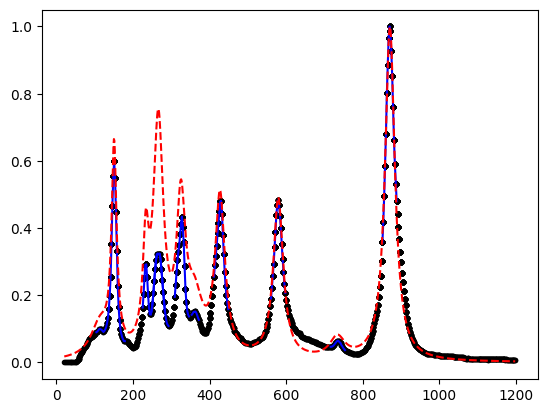

In [120]:
plt.plot(x_arr, y_arr, 'k.')
x_fit = np.linspace(np.min(x_arr), np.max(x_arr), 1000)
y_fit = np.zeros_like(x_fit)

for i in range(len(peaks)):
    d_wn = [11,30,10,20,25,20,10,20,20,20,20]
    rng = (x_arr>x_arr[peaks[i]]-d_wn[i]) & (x_arr<x_arr[peaks[i]]+d_wn[i])
    x_rng = x_arr[rng]
    y_rng = y_arr[rng]
    plt.plot(x_rng, y_rng, 'b-', markersize=1)

    popt, pcov = curve_fit(lorentzian, x_rng, y_rng, p0=[x_arr[peaks[i]],1,1])
    y_fit += lorentzian(x_fit, *popt)

plt.plot(x_fit, y_fit, 'r--')
#plt.xlim([200,400])

In [121]:
np.savetxt("raman_data_LNB.txt", np.column_stack((x_arr, y_arr)), header="Raman Shift (cm^-1)    Normalized Intensity (a.u.)")